In [1]:
import sys
sys.path.append('../helper_functions/')

In [2]:
import uproot
import numpy as np
import pandas as pd
import glob
import networkx as nx
import dgl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import importlib
import file_loading
import pdg_id_dict
importlib.reload(file_loading)
importlib.reload(pdg_id_dict)

from file_loading import *
from pdg_id_dict import *

In [3]:
import importlib
import helper_functions
import graph_edm
import graph_plotting
import dataset_functions
import gnn_model
importlib.reload(helper_functions)
importlib.reload(graph_edm)
importlib.reload(graph_plotting)
importlib.reload(dataset_functions)
importlib.reload(gnn_model)

from helper_functions import *
from graph_edm import *
from graph_plotting import *
from dataset_functions import *
from gnn_model import *

In [39]:
glob.glob('*.h5')

['f_16_bjets.h5',
 'f_16_cjets.h5',
 'f_16_ujets.h5',
 'f_17_bjets.h5',
 'f_17_cjets.h5',
 'f_17_ujets.h5',
 'test.h5']

In [61]:
flist = ['/Users/jshlomi/Box/FlavourTagging/JetGraphs/GNN/Dataset/batch_system_scripts/test/f_11_bjets.h5',
 '/Users/jshlomi/Box/FlavourTagging/JetGraphs/GNN/Dataset/batch_system_scripts/test/f_11_cjets.h5']

flist_valid = [
 '/Users/jshlomi/Box/FlavourTagging/JetGraphs/GNN/Dataset/batch_system_scripts/test/f_0_bjets.h5',
 '/Users/jshlomi/Box/FlavourTagging/JetGraphs/GNN/Dataset/batch_system_scripts/test/f_0_cjets.h5',
 '/Users/jshlomi/Box/FlavourTagging/JetGraphs/GNN/Dataset/batch_system_scripts/test/f_0_ujets.h5']

In [62]:
df_list = []
for fname in flist:
    f = h5py.File(fname,'r')
    keylist = [x for x in f.keys()]
    f.close()
    print(keylist)
    df_list.append(pd.concat( [pd.read_hdf(fname,key=x)  for x in keylist] ) )

graph_df = pd.concat( df_list )

['df_0', 'df_1', 'df_10', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_16', 'df_17', 'df_18', 'df_19', 'df_2', 'df_20', 'df_21', 'df_22', 'df_23', 'df_24', 'df_25', 'df_26', 'df_27', 'df_28', 'df_3', 'df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_9']
['df_0', 'df_1', 'df_10', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_16', 'df_17', 'df_18', 'df_19', 'df_2', 'df_20', 'df_21', 'df_22', 'df_23', 'df_24', 'df_25', 'df_26', 'df_27', 'df_28', 'df_3', 'df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_9']


In [65]:
len(graph_df)

43161

In [63]:
graph_df = graph_df.sample(frac=0.4).reset_index(drop=True)

In [64]:
len( np.where( graph_df.jet_DoubleHadLabel.values == 5 )[0] )

21609

In [23]:
df_list = []
for fname in flist_valid:
    f = h5py.File(fname,'r')
    keylist = [x for x in f.keys()]
    f.close()
    print(keylist)
    df_list.append(pd.concat( [pd.read_hdf(fname,key=x)  for x in keylist] ) )

graph_df_valid = pd.concat( df_list )

['df_0', 'df_1', 'df_2', 'df_3']
['df_0', 'df_1', 'df_2', 'df_3']
['df_0', 'df_1', 'df_2', 'df_3']


In [367]:
#graph_df_valid = graph_df_valid.sample(frac=0.1).reset_index(drop=True)

In [24]:
len(graph_df_valid)

21090

In [66]:
ds = JetGraphDataset([graph_df])
ds_valid = JetGraphDataset([graph_df_valid])

In [67]:
dataset_loader = torch.utils.data.DataLoader(ds,
                                             batch_size=10, shuffle=True,collate_fn=create_batch,
                                             num_workers=1)

dataset_loader_valid = torch.utils.data.DataLoader(ds_valid,
                                             batch_size=150, shuffle=False,collate_fn=create_batch,
                                             num_workers=1)

In [29]:
import importlib
import gnn_model
importlib.reload(gnn_model)

from gnn_model import *

In [68]:
ce_loss = nn.CrossEntropyLoss(reduction='mean')

def loss_function(node_class,node_labels):
    
    batch_s = len(node_class)
    
    node_labels[ node_labels < 2 ] = 0
    node_labels[ node_labels > 4 ] = 4
    node_labels[ node_labels > 1 ] = node_labels[ node_labels > 1 ]-1
    node_labels[ node_labels > 2 ] = 0
    
    total_loss = ce_loss(node_class,node_labels)
    
    return total_loss

In [69]:
j_gnn = JetNodeClassifier(hidden_size=128,n_classes=3)

In [70]:
for x,y in dataset_loader:
    break
    
jet_features = x[0]
g = x[1]
node_features = x[2]

In [71]:
j_gnn.train();

In [72]:
output = j_gnn(jet_features,g,node_features)

In [73]:
loss_function(output,y).item()

1.1667041778564453

In [74]:
import fastai
from fastai import *
from fastai.vision import *

In [75]:
db = DataBunch(train_dl=dataset_loader,valid_dl=dataset_loader_valid,collate_fn=create_batch,fix_dl=dataset_loader)

In [76]:
learn = Learner(db,j_gnn,loss_func=loss_function)

In [77]:
learn.fit(4,lr=1e-03)

epoch,train_loss,valid_loss,time
0,0.484234,0.443518,13:13


KeyboardInterrupt: 

In [58]:
learn.fit(2,lr=1e-03)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [78]:
torch.save(j_gnn, 'model_test.pt')

In [59]:
learn.fit(2,lr=1e-04)

epoch,train_loss,valid_loss,time
0,0.414026,0.408308,11:47
1,0.405411,0.407395,11:54


In [437]:
learn.fit(2,lr=1e-05)

epoch,train_loss,valid_loss,time
0,0.545106,0.534128,09:29
1,0.529835,0.530495,09:33


In [438]:
learn.fit(2,lr=1e-05)

epoch,train_loss,valid_loss,time
0,0.531772,0.526839,09:30
1,0.534640,0.523377,09:07


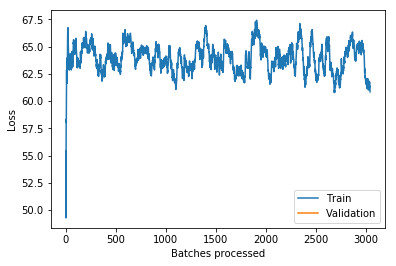

In [181]:
learn.recorder.plot_losses()

In [440]:
j_gnn.eval()

printed = 0
for i in range(len(ds_valid)):

    x,y = create_batch([ds[i]])
    
    try:
        output = j_gnn(x[0],x[1],x[2])
    except RuntimeError:
        print(x)
        
    
    if np.amax(np.argmax( output.data.numpy(),axis=1) ) > 0:
        print( np.amax(np.argmax( output.data.numpy() ,axis=1)  ) )
        print( np.argmax( output.data.numpy() ,axis=1 ) )
        print( y.data.numpy() )
        printed+=1
        if printed > 50:
            break

1
[0 0 0 0 0 0 0 1]
[0 0 1 1 0 1 1 1]
1
[0 0 0 0 1 0 0 0 0]
[2 3 2 0 2 0 1 1 0]
1
[0 0 0 1 0 0 1 0 0 0]
[0 0 1 4 0 4 3 3 0 2]
1
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 1 1 0 0 0 2 0 0 0 1 1 1 1]
1
[0 0 0 0 0 0 0 1 0 0]
[1 0 0 0 2 0 0 2 1 0]
1
[0 0 0 0 1 1 0 0]
[1 1 2 0 2 1 2 1]
1
[0 0 0 0 0 0 1 0 0 0 0]
[0 0 1 1 1 1 1 1 1 0 0]
1
[0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0]
[1 5 0 1 4 1 0 0 1 3 4 4 0 1 4 0 2]
1
[0 1 0 0 0 0 0 0 0 0]
[2 2 1 1 1 1 1 1 1 2]
1
[0 0 0 0 1 1 0 0 0 0 1]
[0 0 1 1 2 2 0 0 0 2 2]
1
[0 0 0 0 0 1 0 0 1 0 0]
[1 0 1 0 0 0 1 0 1 1 1]
1
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[3 0 1 0 2 0 1 0 0 1 0 0 0 0]
1
[0 0 0 0 0 0 0 0 0 1]
[2 1 1 0 0 2 1 1 3 1]
1
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 2 0 2 0 0 0 0 0 1 0 0]
1
[1 1 1 1 0 0]
[3 2 3 2 2 4]
1
[0 0 0 1 1 0 0 1 0 1]
[4 0 0 3 1 0 2 2 0 3]
1
[0 0 1 0 0 0 0 0 0 0]
[1 1 1 0 0 1 0 0 1 2]
1
[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 2 0 1 3 0 1 0 0 1 1 0 0 3 0 0 2]
1
[0 0 1 0 1 0 0 0 0 1 0]
[1 0 1 0 3 0 2 1 0 3 3]
1
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0

In [178]:
losses = []

batch_i = 0
for x,y in dataset_loader:
    batch_i+=1
    jet_features = x[0]
    g = x[1]
    node_features = x[2]
    
    output = j_gnn(x[0],x[1],x[2])
    
    losses.append( loss_function(output,y).item() )
    
    if batch_i > 100:
        break

In [179]:
losses_valid = []

batch_i = 0
for x,y in dataset_loader_valid:
    batch_i+=1
    jet_features = x[0]
    g = x[1]
    node_features = x[2]
    
    output = j_gnn(x[0],x[1],x[2])
    
    losses_valid.append( loss_function(output,y).item() )
    
    if batch_i > 100:
        break

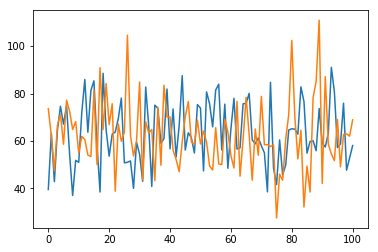

In [180]:
plt.plot(losses)
plt.plot(losses_valid)

In [121]:
f = uproot.open('/Users/jshlomi/Desktop/flav_Akt4EMTo.root')
treename = 'bTag_AntiKt4EMTopoJets'
tree = f[treename]

In [122]:
selectionDF = get_df(f[treename],[selectionVars],['jetlevel'])
df = get_df(f[treename],[jetvars],['jetlevel']) 


selection_cut = ((selectionDF.jet_aliveAfterOR > 0) & (selectionDF.jet_aliveAfterORmu > 0) & 
                (df.jet_pt > 20000) & 
                 (abs(df.jet_eta) < 2.5) & (  (df.jet_JVT > 0.59) | (df.jet_pt > 60000) | (df.jet_eta > 2.4)  )
                )

In [123]:
df = get_df(tree,[graph_variables,jetvars,eventvars],['perjetlevel','jetlevel','eventlevel'])

In [124]:
df = df[selection_cut]

In [201]:
j_gnn.eval();

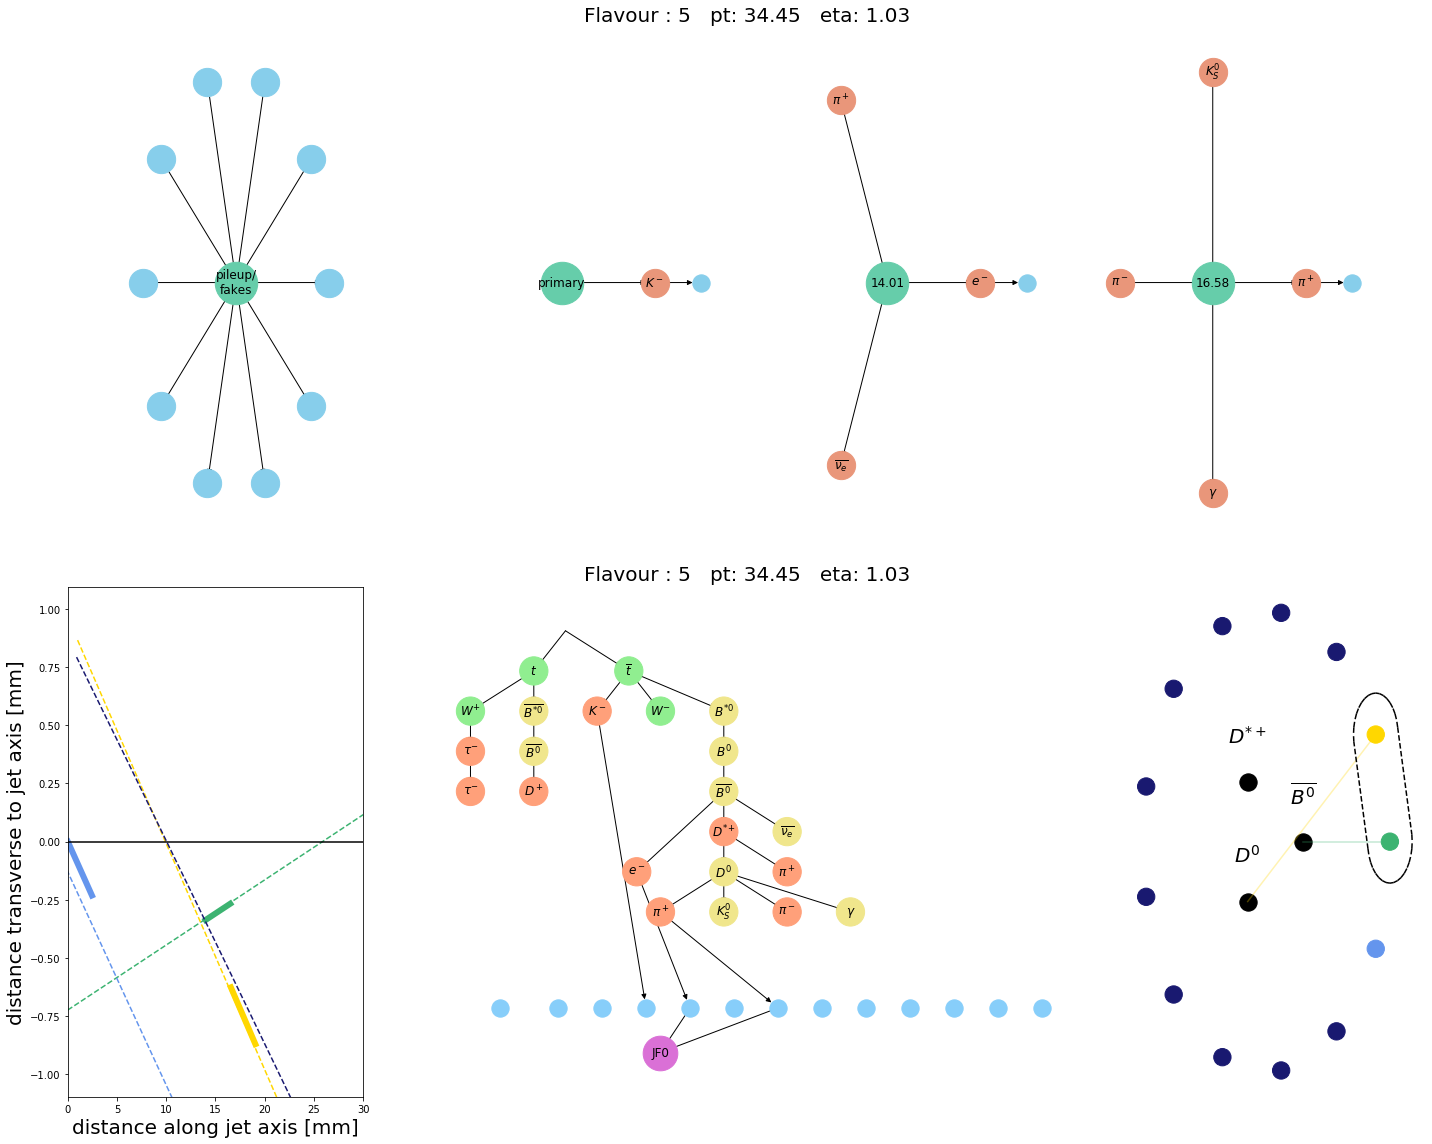

In [169]:
fig = plt.figure(figsize=(20,16))
gs = gridspec.GridSpec(2, 4)


ax_i = plt.subplot(gs[0,:])
ax_j = plt.subplot(gs[0+1,0])
ax_k = plt.subplot(gs[0+1,1:3])
ax_m = plt.subplot(gs[0+1,3:])


ax_i.set_axis_off()

jet_graph = df.iloc[13]
full_graph = build_jet_graph(jet_graph,merging_dist=0)

reco_g = full_graph.get_reco_graph()
reco_g.sort_nodes()

x,y = create_single_batch(reco_g)
output = j_gnn(x[0],x[1],x[2])

create_graph_plot(reco_g,ax_m)

plot_locations(full_graph,ax_i)

plot_tree_graph(jet_graph,ax_k)

plot_graph_jet_image(reco_g,ax_j)


pt = jet_graph.jet_pt
eta = jet_graph.jet_eta
flav = jet_graph.jet_DoubleHadLabel

ax_i.set_title('Flavour : '+str(flav)+'   pt: '+'{0:.2f}'.format(pt/1000.0)+'   eta: '+'{0:.2f}'.format(eta) ,
              fontsize=20)

plt.tight_layout()
plt.show()

In [170]:
np.argmax( output.data.numpy() ,axis=1 )

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [171]:
y

tensor([2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [174]:
torch.softmax( output ,1 ).data.numpy()

array([[9.955835e-01, 5.294890e-09, 7.760824e-04, 1.478271e-05, ..., 1.985516e-05, 3.407154e-03, 1.874098e-04,
        1.117061e-08],
       [9.956119e-01, 8.444732e-09, 7.042669e-04, 1.563942e-05, ..., 1.862338e-05, 3.450492e-03, 1.877261e-04,
        1.135494e-08],
       [9.931467e-01, 1.960215e-09, 5.277707e-04, 1.697514e-05, ..., 1.245518e-05, 6.157045e-03, 1.318415e-04,
        1.096867e-08],
       [9.928622e-01, 1.486417e-08, 8.319001e-04, 2.114512e-05, ..., 1.880950e-05, 6.071725e-03, 1.853825e-04,
        1.315454e-08],
       ...,
       [9.994372e-01, 6.882122e-13, 3.518674e-05, 5.977873e-07, ..., 1.155900e-07, 5.249070e-04, 1.978070e-06,
        2.064860e-12],
       [9.983146e-01, 3.403661e-10, 4.667118e-04, 1.558053e-06, ..., 2.255535e-06, 1.188304e-03, 2.584771e-05,
        2.119331e-10],
       [9.991453e-01, 5.541021e-11, 3.180579e-05, 4.788885e-06, ..., 4.702173e-07, 8.003516e-04, 1.638412e-05,
        8.338215e-11],
       [9.964827e-01, 9.526437e-09, 5.661558e-04, 